# Project: Retail Baskets

Following [this project](https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis?scriptVersionId=7832599) for a-priori analysis with Python using Orange3.

It runs on Google colab rather than Kaggle. The association rules needs a lot of memory.

The Charts section performs some cluster analysis and develops some metrics that are not used further.

The basket data is from an on-line store's gifts and partyware section : selling mostly party goods, baking supplies and cheap gifts

## Loading: Code and Data

### Code

My module and pandasql

In [79]:
# weaves
# I have my utilities available in this. Check the version loaded is the version used by means of the version check later.
! pip install unidecode
! pip install -v http://walti.mooo.com/weaves-dev.tar.gz

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [80]:
import psutil
display(psutil.virtual_memory().percent)

from weaves import DataFrames 
DataFrames.__version__

28.9

'0.1.2'

In [81]:
## Following
## https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis?scriptVersionId=7832599

! pip install pandasql

In [82]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## BEGIN
# weaves

## For loading
import io
from weaves import DataFrames
ds = DataFrames.instance().quality0(pd.DataFrame())

# Get a file from the desktop
from google.colab import files

# To do this
# uploaded = files.upload()

cs_df = None
uploaded = None

Output hidden; open in https://colab.research.google.com to view.

In [84]:
# For plotting set this to reflect the environment
renderer0 = 'colab'

### Data


In [85]:
# The desktop delivers with this
# uploaded = files.upload()

def tryer0(pckl, url, flnm):
  '''
  Try to load file from its pickle, or its URL or its desktop filename.

  The desktop upload is very slow but the HTTP is quicker and use a pickle file
  '''

  try:
    df = pd.read_pickle(pckl)
  except FileNotFoundError:
    try:
      df = pd.read_csv(url)
    except Exception:
      uploaded = files.upload()
      df = pd.read_excel(io.BytesIO(uploaded[flnm]))

  df.to_pickle(pckl)
  return df

In [86]:
cs_df = tryer0('retail.pckl', 'http://walti.mooo.com/Online%20Retail.csv', 'Online Retail.xlsx')

In [87]:
def rstr(df, pred=None): 
    return DataFrames.instance().quality0(df, predictor=pred)

In [88]:
type(cs_df)
## END

pandas.core.frame.DataFrame

## Wrangling

Correcting the dataset

In [89]:
details = rstr(cs_df)
display(details.sort_values(by='missingP', ascending=False))

,types,counts,distincts,nulls,missingP,skewness,kurtosis,uniques,count,mean,std,min,25%,50%,75%,max
CustomerID,float64,406829,4373,135080,0.249267,0.029835,-1.179982,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0
Description,object,540455,4224,1454,0.002683,NaN,NaN,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,NaN,NaN,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,object,541909,4070,0,0.000000,NaN,NaN,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,int64,541909,722,0,0.000000,-0.264076,119769.160031,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
InvoiceDate,object,541909,23260,0,0.000000,NaN,NaN,"[01/12/2010 08:26, 01/12/2010 08:28, 01/12/201...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,186.506972,59005.719097,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
Country,object,541909,38,0,0.000000,NaN,NaN,"[United Kingdom, France, Australia, Netherland...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
print('Check if we had negative quantity and prices at same register:',
     'No' if cs_df[(cs_df.Quantity<0) & (cs_df.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')
print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      cs_df[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0)].shape[0])
print('\nWhat is the customer ID of the registers above:',
      cs_df.loc[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0), 
                ['CustomerID']].CustomerID.unique())
print('\n% Negative Quantity: {:3.2%}'.format(cs_df[(cs_df.Quantity<0)].shape[0]/cs_df.shape[0]))
print('\nAll register with negative quantity has Invoice start with:', 
      cs_df.loc[(cs_df.Quantity<0) & ~(cs_df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())
print('\nSee an example of negative quantity and others related records:')
display(cs_df[(cs_df.CustomerID==12472) & (cs_df.StockCode==22244)])

Check if we had negative quantity and prices at same register: No 

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336

What is the customer ID of the registers above: [nan]

% Negative Quantity: 1.96%

All register with negative quantity has Invoice start with: ['C']

See an example of negative quantity and others related records:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [91]:
print('Check register with UnitPrice negative:')
display(cs_df[(cs_df.UnitPrice<0)])
print("Sales records with Customer ID and zero in Unit Price:",cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())].shape[0])
cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())]

Check register with UnitPrice negative:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,12/08/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,12/08/2011 14:52,-11062.06,NaN,United Kingdom


Sales records with Customer ID and zero in Unit Price: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,05/12/2010 14:02,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,16/12/2010 14:36,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,21/12/2010 13:45,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,06/01/2011 16:41,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,06/01/2011 16:41,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,13/01/2011 15:10,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,10/02/2011 13:08,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,23/03/2011 10:25,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,30/03/2011 12:45,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,04/04/2011 14:42,0.0,14410.0,United Kingdom


In [92]:
# Remove register without CustomerID
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.Quantity<0)]
cs_df = cs_df[cs_df.UnitPrice>0]

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

,types,counts,distincts,nulls,missingP,skewness,kurtosis,uniques,count,mean,std,min,25%,50%,75%,max
InvoiceNo,object,397884,18532,0,0.0,-0.178524,-1.200748,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InvoiceDate,object,397884,17282,0,0.0,NaN,NaN,"[01/12/2010 08:26, 01/12/2010 08:28, 01/12/201...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerID,float64,397884,4338,0,0.0,0.025729,-1.180822,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",397884.0,15294.423453,1713.141560,12346.000,13969.00,15159.00,16795.00,18287.00
Description,object,397884,3877,0,0.0,NaN,NaN,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,object,397884,3665,0,0.0,NaN,NaN,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,float64,397884,440,0,0.0,204.032727,58140.396673,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",397884.0,3.116488,22.097877,0.001,1.25,1.95,3.75,8142.75
Quantity,int64,397884,301,0,0.0,409.892972,178186.243253,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",397884.0,12.988238,179.331775,1.000,2.00,6.00,12.00,80995.00
Country,object,397884,37,0,0.0,NaN,NaN,"[United Kingdom, France, Australia, Netherland...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After this first cleanup, note that we still have more description than inventory codes, so we still have some inconsistency on the basis that requires further investigation. Let´s see it:

In [93]:
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()
display(cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head())

,index,StockCode
0,23236,4
1,23196,4
2,22937,3
3,23535,3
4,23396,3


In [94]:
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index()['index'][4]]['Description'].unique()

array(['BUTTERFLY CUSHION COVER', 'LA JARDIN BOTANIQUE CUSHION COVER',
       'LE JARDIN BOTANIQUE CUSHION COVER'], dtype=object)

This gives the multiple descriptions for one of those items and we witness the simple ways in which data quality can be corrupted in any dataset. A simple spelling mistake can end up in reducing data quality and an erroneous analysis.

In [95]:
unique_desc = cs_df[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from cs_df as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

cs_df = pysqldf(q)

In [96]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice
cs_df.CustomerID = cs_df.CustomerID.astype('Int64')

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

,types,counts,distincts,nulls,missingP,skewness,kurtosis,uniques,count,mean,std,min,25%,50%,75%,max
InvoiceNo,object,397884,18532,0,0.0,-0.178524,-1.200748,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InvoiceDate,datetime64[ns],397884,17282,0,0.0,NaN,NaN,"[2010-01-12T08:26:00.000000000, 2010-01-12T08:...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerID,Int64,397884,4338,0,0.0,0.025729,-1.180822,"[17850, 13047, 12583, 13748, 15100, 15291, 146...",397884.0,15294.423453,1713.141560,12346.000,13969.00,15159.00,16795.00,18287.00
StockCode,object,397884,3665,0,0.0,NaN,NaN,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,object,397884,3647,0,0.0,NaN,NaN,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,float64,397884,2939,0,0.0,451.443182,232155.117219,"[15.299999999999999, 20.34, 22.0, 15.3, 25.5, ...",397884.0,22.397000,309.071041,0.001,4.68,11.80,19.80,168469.60
UnitPrice,float64,397884,440,0,0.0,204.032727,58140.396673,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",397884.0,3.116488,22.097877,0.001,1.25,1.95,3.75,8142.75
Quantity,int64,397884,301,0,0.0,409.892972,178186.243253,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",397884.0,12.988238,179.331775,1.000,2.00,6.00,12.00,80995.00
Country,object,397884,37,0,0.0,NaN,NaN,"[United Kingdom, France, Australia, Netherland...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Charts: Amount

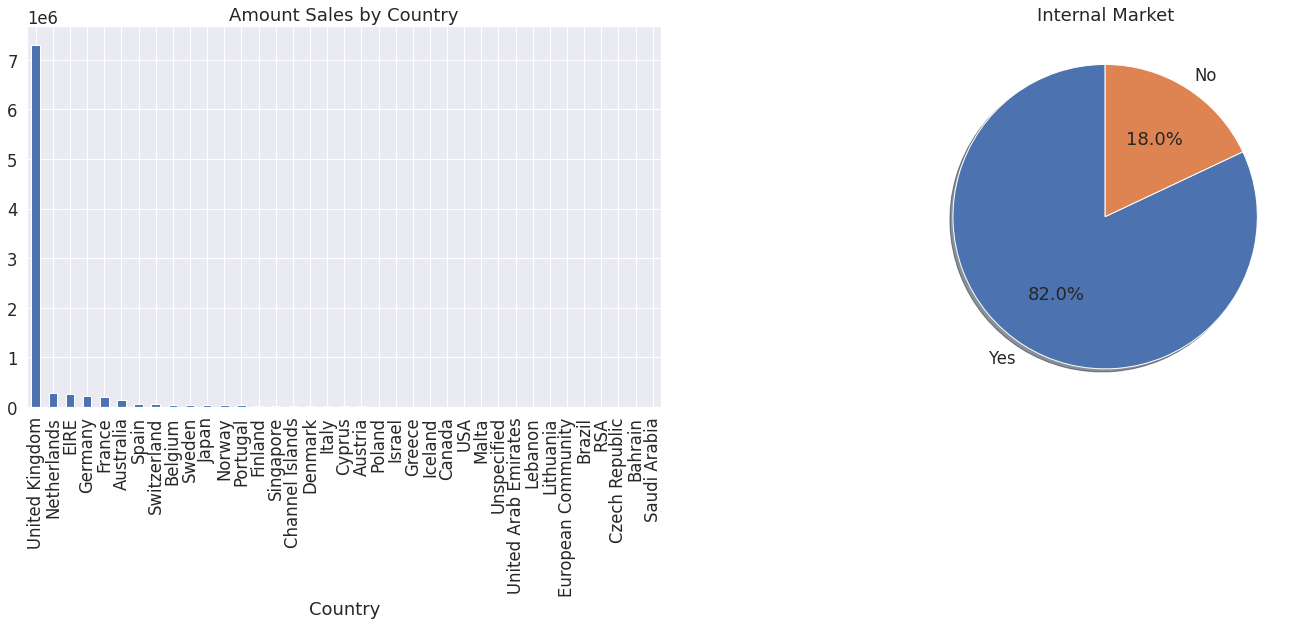

In [97]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = cs_df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
cs_df['Internal'] = cs_df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = cs_df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

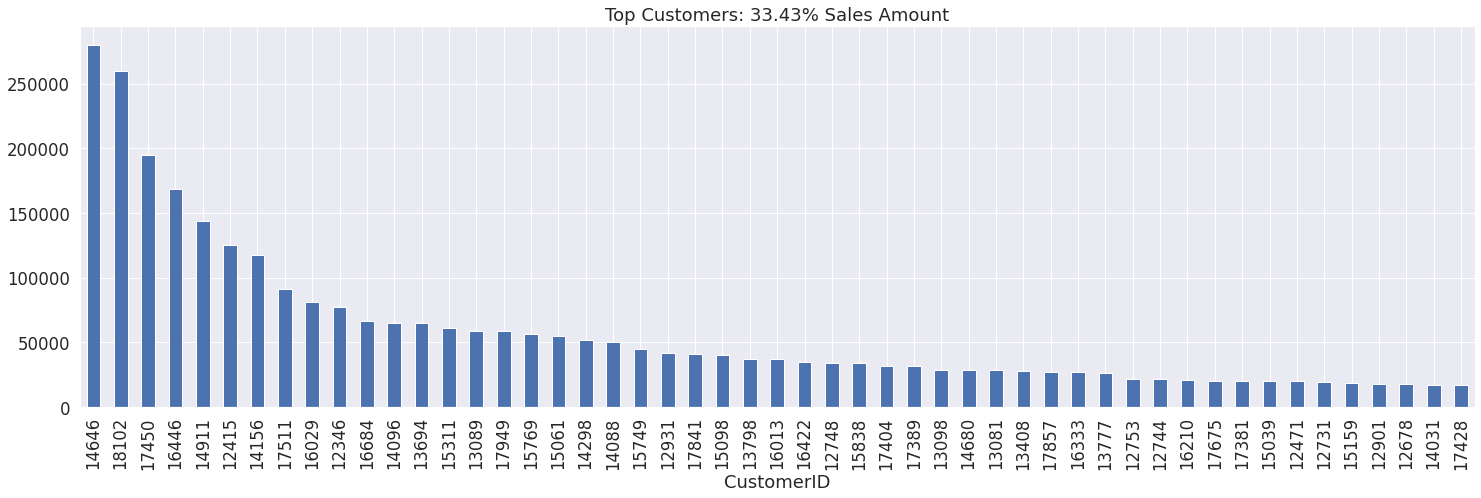

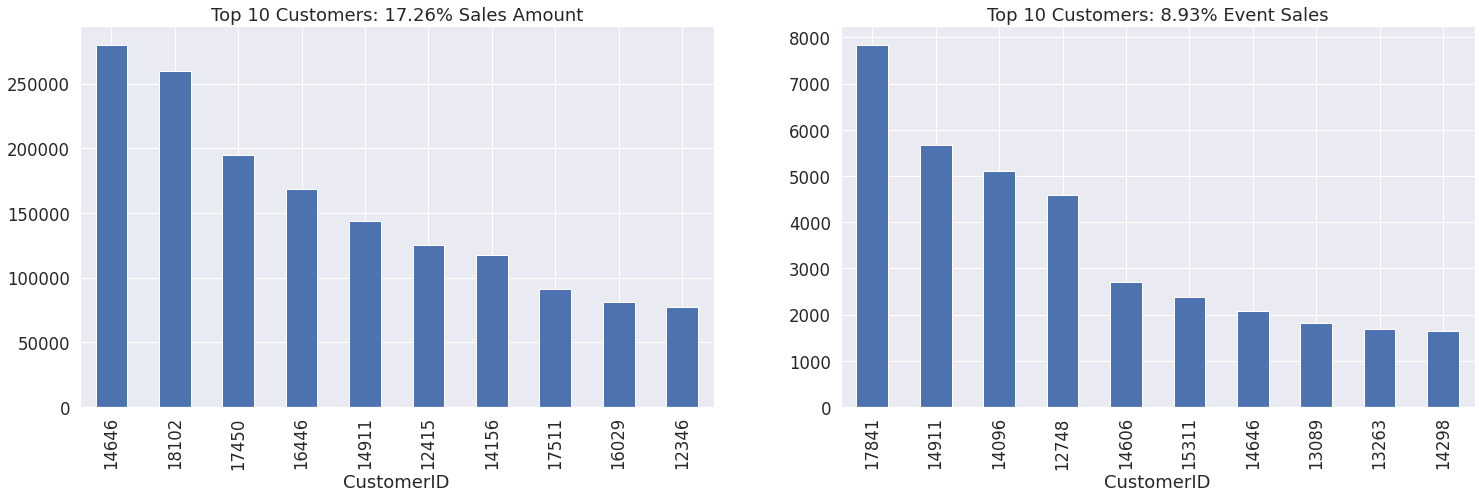

In [98]:
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)

fig = plt.figure(figsize=(25, 7))
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amount'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

In [137]:
AmoutSum = cs_df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = cs_df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

NameError: ignored

### Customer Segmentation

Customer segmentation is similarly the process of dividing an organization’s customer bases into different sections or segments based on various customer attributes. The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

The major objectives and benefits behind the motivation for customer segmentation are:

    Higher Revenue: This is the most obvious requirement of any customer segmentation project.
    Customer Understanding: One of the mostly widely accepted business paradigms is “know your customer” and a segmentation of the customer base allows for a perfect dissection of this paradigm.
    Target Marketing: The most visible reason for customer segmentation is the ability to focus marketing efforts effectively and efficiently. If a firm knows the different segments of its customer base, it can devise better marketing campaigns which are tailor made for the segment. A good segmentation model allows for better understanding of customer requirements and hence increases the chances of the success of any marketing campaign developed by the organization.
    Optimal Product Placement: A good customer segmentation strategy can also help the firm with developing or offering new products, or a bundle of products together as a combined offering.
    Finding Latent Customer Segments: Finding out which segment of customers it might be missing to identifying untapped customer segments by focused on marketing campaigns or new business development.

### Clustering

The most obvious method to perform customer segmentation is using unsupervised Machine Learning methods like clustering. The method is as simple as collecting as much data about the customers as possible in the form of features or attributes and then finding out the different clusters that can be obtained from that data. Finally, we can find traits of customer segments by analyzing the characteristics of the clusters.

#### Exploratory Data Analysis

Using exploratory data analysis is another way of finding out customer segments. This is usually done by analysts who have a good knowledge about the domain relevant to both products and customers. It can be done flexibly to include the top decision points in an analysis.
RFM Model for Customer Value:

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

Recency: how recently a customer purchased at the establishment

Frequency: How frequently a customer transacts

Monetary value: The dollar (or pounds in our case) value of all the transactions that the customer made

To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.


In [100]:
refrence_date = cs_df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
cs_df['days_since_last_purchase'] = (refrence_date - cs_df.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  cs_df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-11 17:19:00


,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,106.470954,115.082161,1.0,23.00,62.0,162.75,698.0


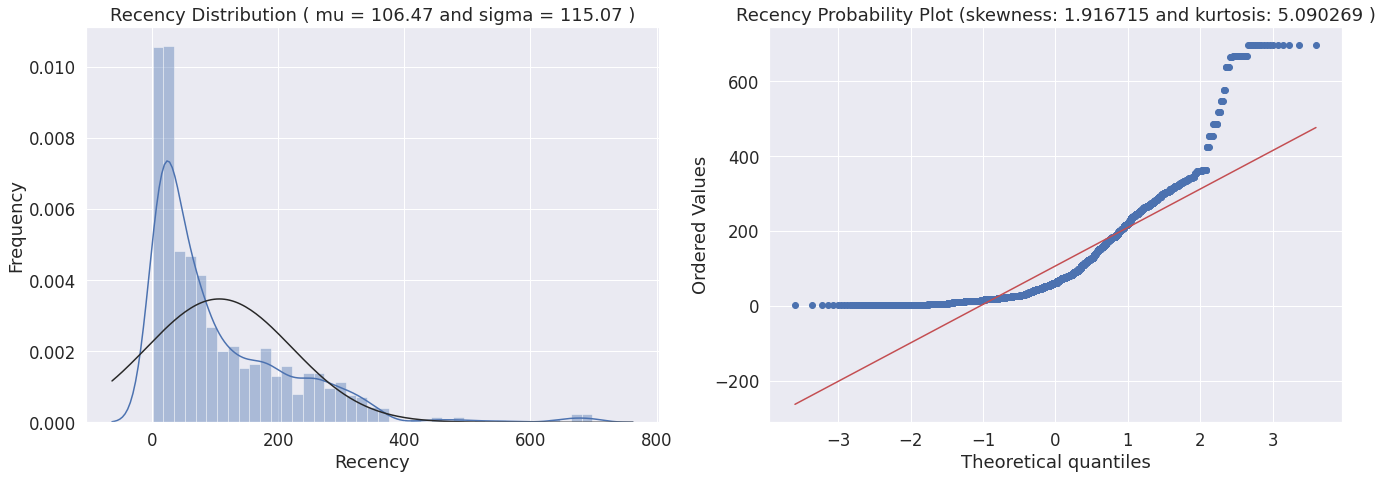

In [101]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

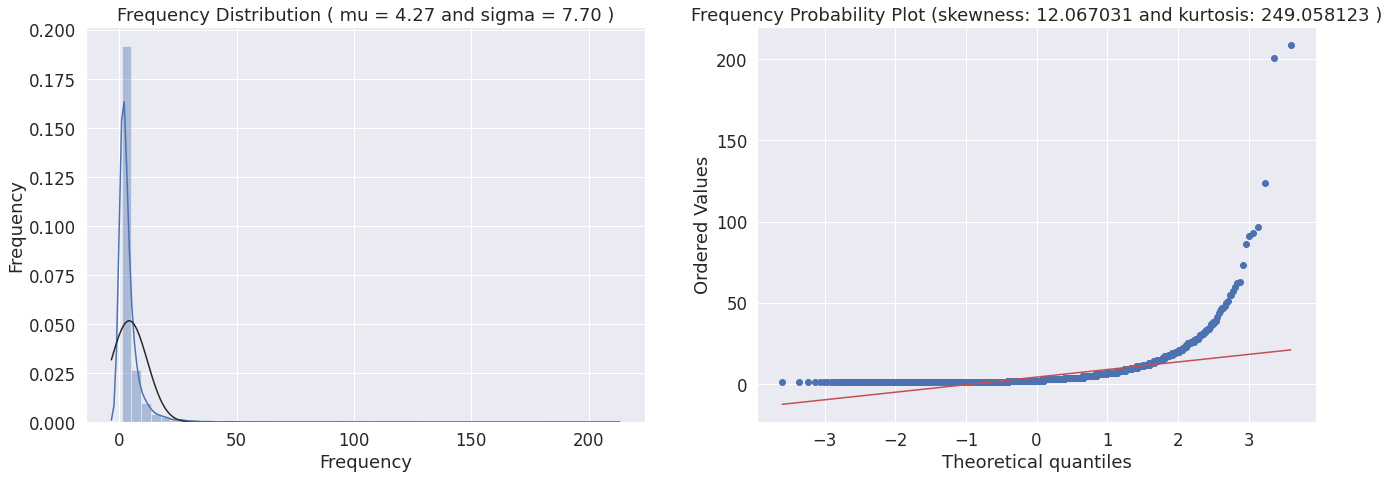

In [102]:
customer_freq = (cs_df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

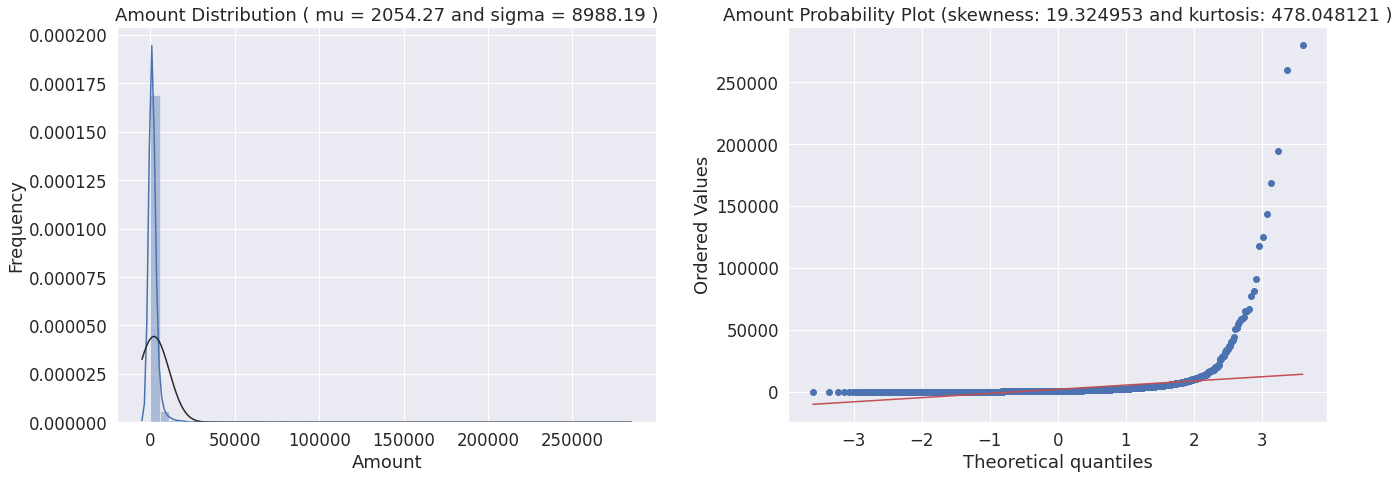

In [103]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

In [104]:
customer_history_df.describe()

,CustomerID,recency,frequency,amount
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,106.470954,4.272015,2054.266460
std,1721.808492,115.082161,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,23.000000,1.000000,307.415000
50%,15299.500000,62.000000,2.000000,674.485000
75%,16778.750000,162.750000,5.000000,1661.740000
max,18287.000000,698.000000,209.000000,280206.020000


In [105]:
idx0 = customer_history_df['amount'] <= 0
customer_history_df[idx0]

,CustomerID,recency,frequency,amount


In [106]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
amount_log,4338.0,-1.202102e-16,1.000115,-4.179280,-0.684183,-0.060942,0.654244,4.721395
recency_log,4338.0,2.352506e-16,1.000115,-3.001707,-0.647671,0.096823,0.821375,1.914502
frequency_log,4338.0,-2.355833e-16,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714


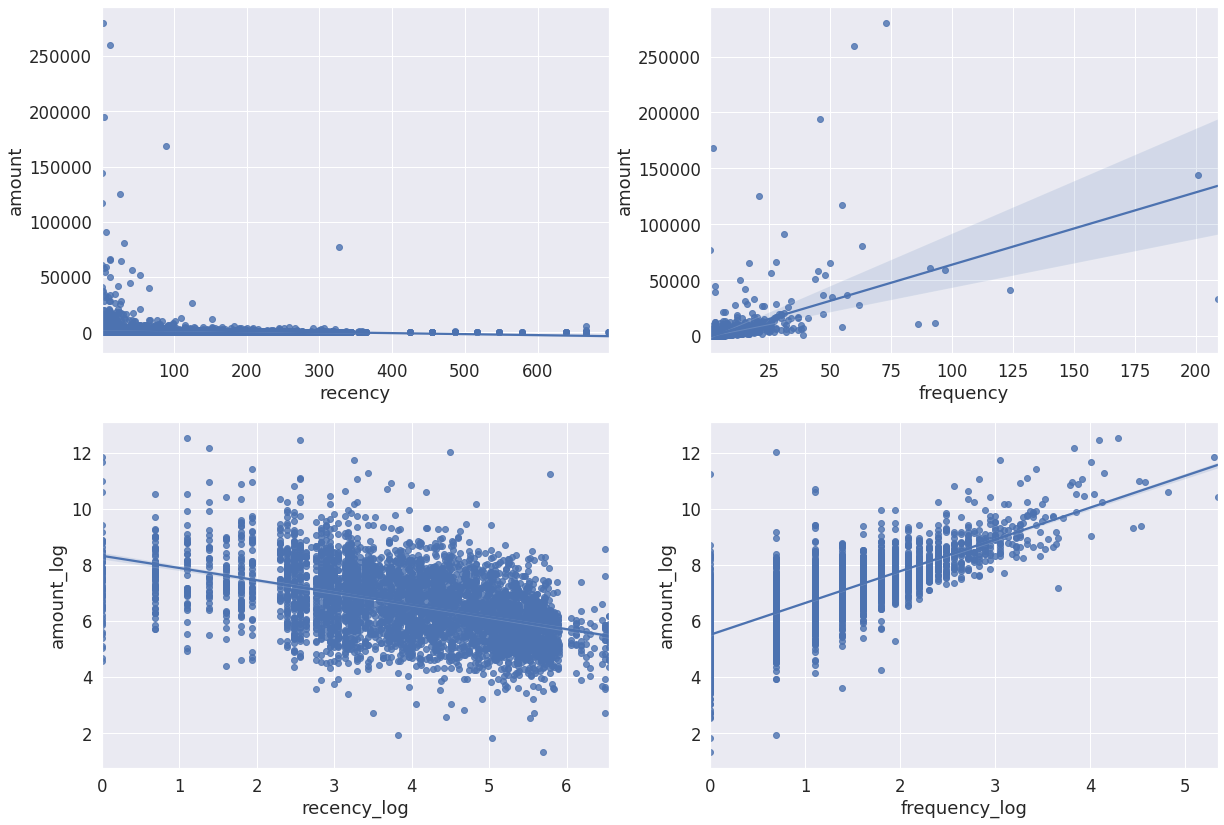

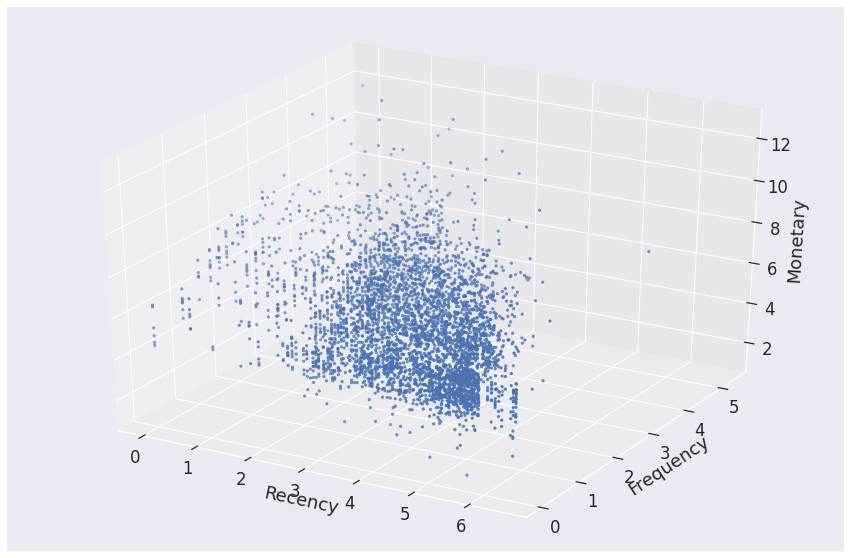

In [107]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

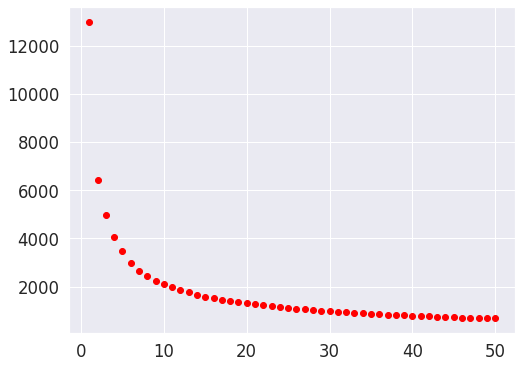

The best K suggest:  7


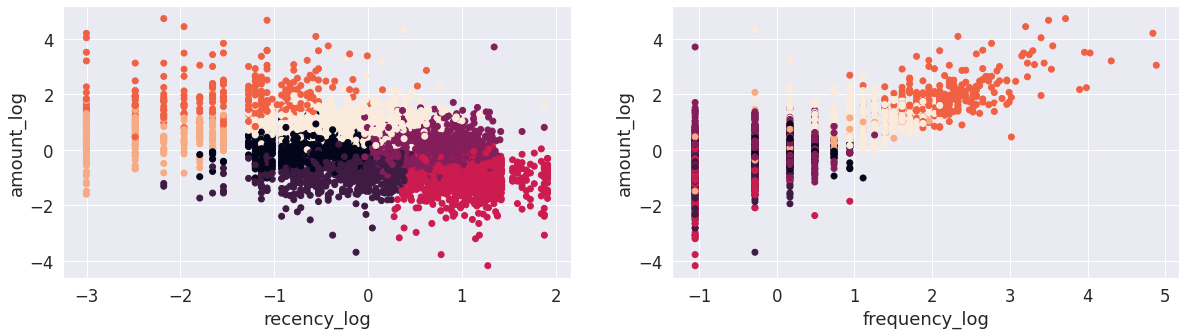

In [108]:
## Time-consuming

cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K suggest: ', K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

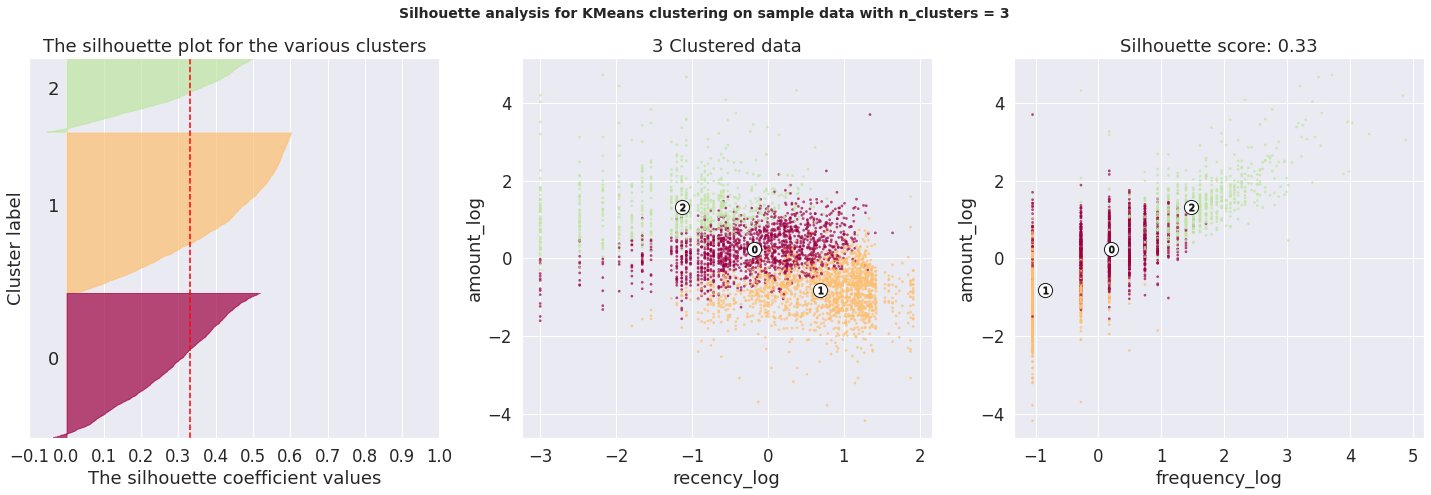

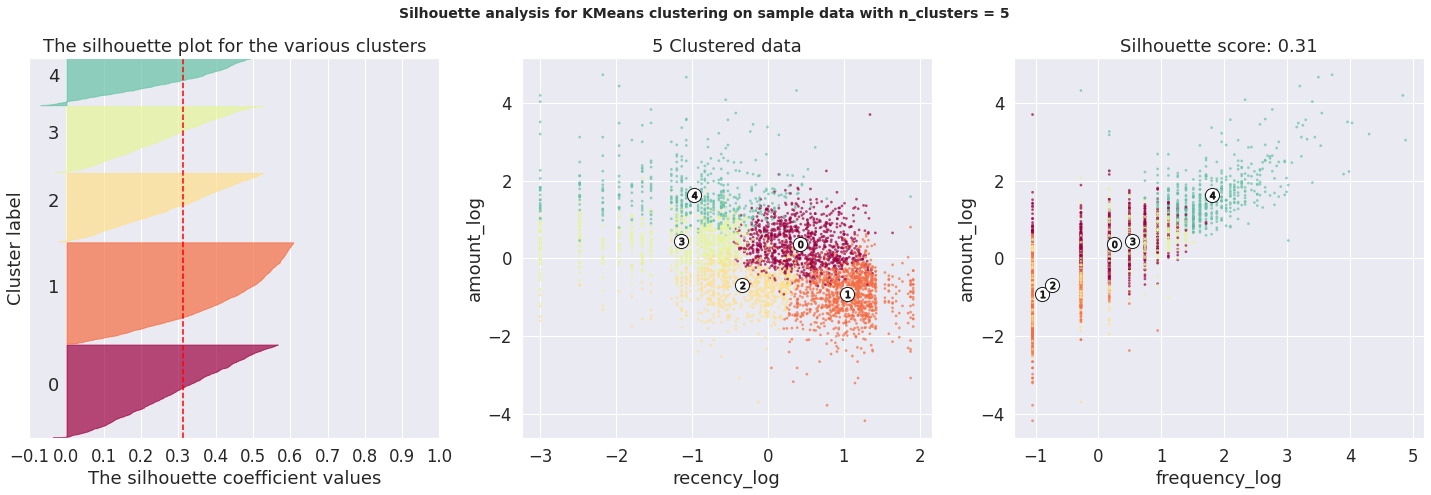

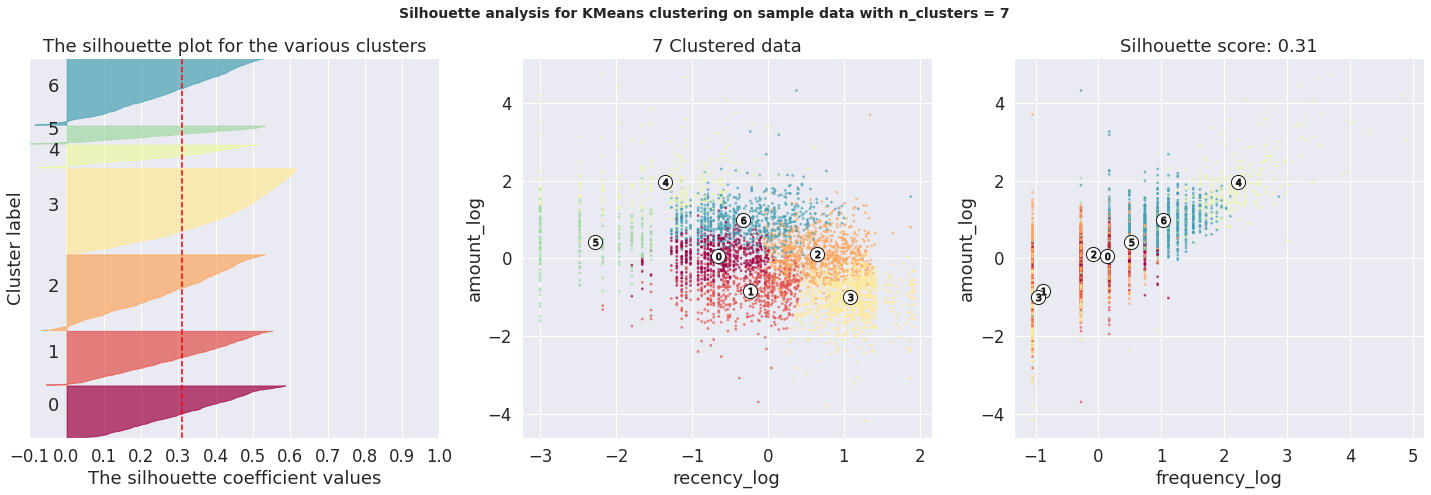

In [109]:
## Charts
# Silhouette plots

cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [110]:
## Quantify

features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.33
Centers of each cluster:
        amount     recency  frequency
0   975.134755   42.554643   3.058822
1   258.840252  136.175355   1.190321
2  3873.223556   12.152236   9.724675
--------------------------------------------------
for 5 clusters the silhouette score is 0.31
Centers of each cluster:
        amount     recency  frequency
0  1140.436970   95.902147   3.206769
1   232.284993  216.981477   1.139123
2   307.933316   34.322490   1.324227
3  1279.715692   11.888334   4.149266
4  5686.642986   14.943658  13.055950
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
        amount     recency  frequency
0   784.974502   22.663550   2.906553
1   252.846148   39.825295   1.167055
2   842.616768  129.089977   2.360880
3   206.164090  228.336590   1.084865
4  8719.956916    8.894820  19.053036
5  1250.485583    2.607807   4.107490
6  2536.027226   35.379822   6.517325
-------

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_3,clusters_5,clusters_7
0,12346,327.0,1,77183.60,5.789960,0.000000,11.253942,0,0,2
1,12347,41.0,7,4310.00,3.713572,1.945910,8.368693,2,4,6
2,12348,77.0,4,1797.24,4.343805,1.386294,7.494007,0,0,6
3,12349,20.0,1,1757.55,2.995732,0.000000,7.471676,0,2,0
4,12350,312.0,1,334.40,5.743003,0.000000,5.812338,1,1,3


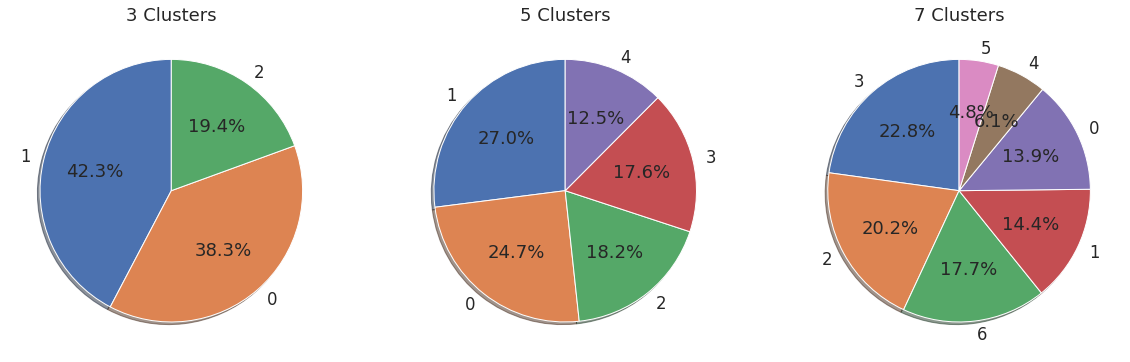

In [111]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

In [112]:
## Get some sense of the range

x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        # py.offline.iplot(fig)
        fig.show(renderer=renderer0)

## A-priori Analysis

This is similar to the R system. It's a very slow algorithm so only the top part of the dataset is processed. It needs at least 12G of memory for the top 15 items, see *ncount* below.

The documents for the Orange packages are [here](https://orange3-associate.readthedocs.io/en/latest/scripting.html).

The key metric is [lift](https://en.wikipedia.org/wiki/Lift_(data_mining)). It should be greater than 1, which indicates there is no relationship between consequent and antecedent.

### Cream of the Dataset

Produce a dataset of transactions, pickle and then reset.

In [113]:
items = list(cs_df.Description.unique())
grouped = cs_df.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

transaction_df.to_pickle('trans.pckl')

### Run: Association Rules 

Run from here once pickled. Try and delete large tables so that their memory can be re-used.


In [38]:
## With a saved transaction set, the memory can be cleared.
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# Limit the items processed - top 15 does not fit into the 12G available, it can take over 5 minutes.
nstart = 0
ncount = 15
ntrans = 2

s0 = f'For {ncount} products, starting from item {nstart} in baskets of {ntrans} items or more'
print(s0)

# sitems = list(inv[nstart:(nstart+ncount)].index)
# s1 = 'Total sales amount {:.2f}'.format(AmoutSum[sitems].sum())

For 15 products, starting from item 0 in baskets of 2 items or more


In [3]:
import psutil
# See what memory we have
print('Memory in use: ' + str(psutil.virtual_memory().percent))

import pandas as pd

transaction_df = pd.read_pickle('trans.pckl')
transaction_df.shape

Memory in use: 6.2


(18532, 3647)

In [4]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, nitems = 15, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif start_item is not None:
        selected_items = list(item_count[start_item:(start_item+nitems)].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[start_item:(start_item+nitems)]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]

In [5]:
## Runtime considerations 
# From here, we can prune and pickle the data
# Reset the runtime and load the pickles.

output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=ntrans, start_item = nstart, nitems = ncount)
item_counts

del transaction_df, item_counts

print(s0)
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

For 15 products, starting from item 0 in baskets of 2 items or more
Number of Sales Events: 4664
Number of Products: 15


### Association Rules

In [6]:
## The framework in Python (from R).
!pip install orange3
## For association rules
!pip install orange3-associate

In [7]:
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

In [8]:
input_assoc_rules = output_df
del output_df

# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])

# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules.to_numpy(),Y= None)

# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [11]:
# See what memory is left
print('Memory in use: ' + str(psutil.virtual_memory().percent))

Memory in use: 6.6


In [12]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

names = {item: '{}={}'.format(var.name, val)
    for item, var, val in OneHot.decode(mapping, data_tran, mapping)}

eligible_ante = [v for k,v in names.items() if v.endswith("1")]

del data_tran_en, data_tran

num of required transactions =  46
Items Set Size: 663273


Time-consuming: Memory-consuming: this is the analysis.
The original code had a limit of 1e6 on the itemsets

In [13]:
confidence = 0.6
rules_df = pd.DataFrame()

rules = [(P, Q, supp, conf)
for P, Q, supp, conf in association_rules(itemsets, confidence)
    if len(Q) == 1 ]

N = input_assoc_rules.shape[0]

rule_stats = list(rules_stats(rules, itemsets, N))

rule_list_df = []
for ex_rule_frm_rule_stat in rule_stats:
    ante = ex_rule_frm_rule_stat[0]            
    cons = ex_rule_frm_rule_stat[1]
    named_cons = names[next(iter(cons))]
    if named_cons in eligible_ante:
        rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
        ante_rule = ', '.join(rule_lhs)
        if ante_rule and len(rule_lhs)>1 :
            rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                          'confidence' : ex_rule_frm_rule_stat[3],
                          'coverage' : ex_rule_frm_rule_stat[4],
                          'strength' : ex_rule_frm_rule_stat[5],
                          'lift' : ex_rule_frm_rule_stat[6],
                          'leverage' : ex_rule_frm_rule_stat[7],
                          'antecedent': ante_rule,
                          'consequent':named_cons[:-2] }
            rule_list_df.append(rule_dict)
rules_df = pd.DataFrame(rule_list_df)
print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
if not rules_df.empty:
    pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
else:
    print("Unable to generate any rule")

Raw rules data frame of 25247 rules generated


In [14]:
# Set display width
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100

In [15]:
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['confidence', 'support', 'lift'],
                                                   ascending=False)).head()

,consequent,antecedent,support,confidence,lift
20,JUMBO BAG VINTAGE DOILY,"JUMBO BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT, LUNCH BAG VINTAGE DOILY",60,0.909091,4.520256
133,LUNCH BAG VINTAGE DOILY,"LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG BLACK SKULL., LUNCH BAG SUKI DESIGN",49,0.890909,4.596460
134,LUNCH BAG VINTAGE DOILY,"LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN",48,0.888889,4.586037
131,LUNCH BAG VINTAGE DOILY,"LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG BLACK SKULL.",48,0.872727,4.502655
21,JUMBO BAG VINTAGE DOILY,"JUMBO BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN , LUNCH BAG VINTAGE DOILY",48,0.872727,4.339446


In [16]:
pd.options.display.max_colwidth = dw

In [17]:
## END